In [1]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('/kaggle/input/annotations/via_project_21Aug2024_12h45m_csv.csv')

# Create lists to store the images and labels
images = []
labels = []

FIXED_HEIGHT = 45

# Iterate through the annotations
for index, row in df.iterrows():
    filename = row['filename']
    region_shape = eval(row['region_shape_attributes'])  # Convert string to dictionary
    region_attr = eval(row['region_attributes'])  # Convert string to dictionary
    
    # Extract bounding box coordinates
    x = region_shape['x']
    y = region_shape['y']
    width = region_shape['width']
    height = region_shape['height']
    
    # Extract the text label
    text = region_attr['text']
    
    # Load and crop the image
    image = cv2.imread(f'/kaggle/input/resized-journal-scans/resized_journal_scans/{filename}')
    cropped = image[y:y+height, x:x+width]
    
    # Resize the image to have a fixed height while maintaining aspect ratio
    aspect_ratio = width / height
    new_width = int(FIXED_HEIGHT * aspect_ratio)
    resized_image = cv2.resize(cropped, (new_width, FIXED_HEIGHT))
    
    # Convert to grayscale and normalize
    resized_image = cv2.resize(cropped, (new_width, FIXED_HEIGHT))
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    resized_image = resized_image.astype(np.float32) / 255.0
    resized_image = np.expand_dims(resized_image, axis=-1) 
    
    images.append(resized_image)
    labels.append(text)
    
# Keep images as a list, don't convert to numpy array
labels = np.array(labels)

2024-08-28 15:41:49.613225: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 15:41:49.613346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 15:41:49.800794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import plotly.express as px

px.imshow(np.squeeze(images[4]), color_continuous_scale='gray')

In [3]:
# Define the maximum label length
max_label_len = max([len(label) for label in labels])

# Character mapping
characters = set("".join(labels))
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Encode labels
encoded_labels = []
for label in labels:
    encoded = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    encoded_labels.append(encoded)

# Pad sequences
encoded_labels = tf.keras.preprocessing.sequence.pad_sequences(encoded_labels, maxlen=max_label_len, padding='post')

In [4]:
# Split data
train_images, val_images, train_labels, val_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

In [5]:
def create_dataset(images, labels, batch_size):
    def gen():
        for img, label in zip(images, labels):
            yield (img, label)
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(FIXED_HEIGHT, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(max_label_len,), dtype=tf.int64)
        )
    ).padded_batch(batch_size, padded_shapes=([FIXED_HEIGHT, None, 1], [None]))

In [6]:
# Create datasets
batch_size = 32
train_dataset = create_dataset(train_images, train_labels, batch_size)
val_dataset = create_dataset(val_images, val_labels, batch_size)

In [7]:
import tensorflow as tf
from tensorflow import keras

def build_model(img_height, num_characters):
    input_img = keras.Input(shape=(img_height, None, 1), name='input_image')
    
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    new_shape = ((img_height // 4), -1, 128)
    x = keras.layers.Reshape(target_shape=new_shape)(x)
    x = keras.layers.Permute((2, 1, 3))(x)
    x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
    
    output = keras.layers.Dense(num_characters + 1, activation='softmax')(x)
    
    model = keras.Model(inputs=input_img, outputs=output)
    return model

# Recreate and retrain the model
model = build_model(FIXED_HEIGHT, len(char_to_num.get_vocabulary()))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 45, None, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 45, None, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, None, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 11, None, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, None, 11, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1408)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     3,409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 74)       │        19,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,994 (15.94 MB)

 Trainable params: 4,177,994 (15.94 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# CTC loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [9]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss=ctc_loss)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.01, restore_best_weights=True)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks=[early_stopping]
)

Epoch 1/1000
     10/Unknown 39s 3s/step - loss: 503.1344

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 485.8952 - val_loss: 131.1777
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - loss: 120.5616 - val_loss: 102.5574
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - loss: 100.0034 - val_loss: 97.4652
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - loss: 94.0537 - val_loss: 93.8984
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - loss: 91.6774 - val_loss: 91.8303
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - loss: 90.3693 - val_loss: 90.8617
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - loss: 89.5780 - val_loss: 89.4913
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - loss: 88.7314 - val_loss: 88.7891
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - loss: 88.1920 - val_loss: 88.0213
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - loss: 87.5792 - val_loss: 87.5641
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - loss: 87.1956 - val_loss: 87.0247
Epoch 12/1000
10/1

In [10]:
import matplotlib.pyplot as plt

def performance_graph(history):
    history_df = pd.DataFrame(history.history)
    history_df.loc[2:, ['loss', 'val_loss']].plot()
    
    print(("Best Validation Loss: {:0.4f}")\
          .format(history_df['val_loss'].min()))

Best Validation Loss: 84.2257


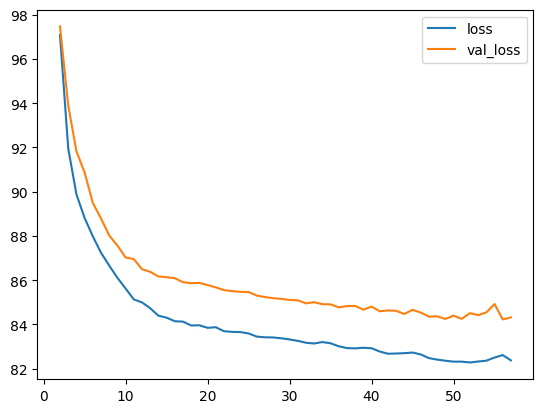

In [11]:
performance_graph(history)

In [12]:
def check_model_output(model, dataset):
    for batch_images, _ in dataset.take(1):
        predictions = model.predict(batch_images)
        print("Model output shape:", predictions.shape)
        print("Sample output (first 5 timesteps, first 5 characters):")
        print(predictions[0, :5, :5])

check_model_output(model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model output shape: (32, 236, 74)
Sample output (first 5 timesteps, first 5 characters):
[[0.00124747 0.02383396 0.01859906 0.00502685 0.001171  ]
 [0.00048248 0.03294493 0.00386147 0.00502594 0.00061991]
 [0.00020384 0.02826524 0.00167508 0.00506524 0.00040663]
 [0.00013321 0.02203809 0.0010477  0.00496054 0.00026292]
 [0.00010967 0.01900061 0.00083845 0.00483014 0.00019153]]


In [13]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    print("Raw prediction shape:", pred.shape)
    print("Sample raw probabilities:")
    print(pred[0, :5, :5])  # Print first 5 timesteps, first 5 characters for the first sample
    
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        result = result.replace("[UNK]", "").strip()
        output_text.append(result)
    return output_text

def decode_label(label):
    return tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

In [14]:
!pip install editdistance
import editdistance

def calculate_cer(y_true, y_pred):
    total_cer = 0
    for true, pred in zip(y_true, y_pred):
        total_cer += editdistance.eval(true, pred) / len(true)
    return total_cer / len(y_true)

def calculate_wer(y_true, y_pred):
    total_wer = 0
    for true, pred in zip(y_true, y_pred):
        true_words = true.split()
        pred_words = pred.split()
        total_wer += editdistance.eval(true_words, pred_words) / len(true_words)
    return total_wer / len(y_true)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 2.4 MB/s eta 0:00:00


In [15]:
def evaluate_model(model, dataset):
    all_predictions = []
    all_ground_truth = []

    for batch_images, batch_labels in dataset:
        batch_predictions = model.predict(batch_images)
        decoded_predictions = decode_batch_predictions(batch_predictions)
        decoded_labels = [decode_label(label) for label in batch_labels]

        all_predictions.extend(decoded_predictions)
        all_ground_truth.extend(decoded_labels)

    cer = calculate_cer(all_ground_truth, all_predictions)
    wer = calculate_wer(all_ground_truth, all_predictions)

    print(f"Character Error Rate: {cer:.4f}")
    print(f"Word Error Rate: {wer:.4f}")

    return all_ground_truth, all_predictions

# Evaluate the model
ground_truth, predictions = evaluate_model(model, val_dataset)
ground_truth = [label.replace("[UNK]", "").strip() for label in ground_truth]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Raw prediction shape: (32, 236, 74)
Sample raw probabilities:
[[0.00124747 0.02383396 0.01859906 0.00502685 0.001171  ]
 [0.00048248 0.03294493 0.00386147 0.00502594 0.00061991]
 [0.00020384 0.02826524 0.00167508 0.00506524 0.00040663]
 [0.00013321 0.02203809 0.0010477  0.00496054 0.00026292]
 [0.00010967 0.01900061 0.00083845 0.00483014 0.00019153]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
Raw prediction shape: (32, 234, 74)
Sample raw probabilities:
[[0.0093049  0.02593875 0.008458   0.00502667 0.03978941]
 [0.006131   0.03558899 0.00252096 0.00415647 0.05042721]
 [0.00366861 0.03377977 0.00140334 0.00355085 0.06203734]
 [0.00306107 0.02929131 0.00085392 0.00314865 0.06263369]
 [0.0029276  0.02507923 0.00062109 0.00287262 0.05944785]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Raw prediction shape: (15, 232, 74)
Sample raw probabilities:
[[0.00121388 0.02464616 0.0188252  0.00493317 0.00135532]
 [0.00051036 0.03364044 0.00377256 0.00471276 0.00080447]


In [16]:
print("Sample ground truth and predictions:")
for gt, pred in zip(ground_truth[:5], predictions[:5]):
    print(f"Ground truth: '{gt}'")
    print(f"Prediction:   '{pred}'")
    print()
    
print("Lengths of first 5 samples:")
for gt, pred in zip(ground_truth[:5], predictions[:5]):
    print(f"Ground truth length: {len(gt)}, Prediction length: {len(pred)}")

Sample ground truth and predictions:
Ground truth: 'that rose after. Humanity has a'
Prediction:   ''

Ground truth: 'stories of their time. These remains'
Prediction:   ''

Ground truth: 'it is'
Prediction:   ''

Ground truth: 'me to a broken hope and lack'
Prediction:   ''

Ground truth: 'weather prediction model. The idea'
Prediction:   ''

Lengths of first 5 samples:
Ground truth length: 31, Prediction length: 0
Ground truth length: 36, Prediction length: 0
Ground truth length: 5, Prediction length: 0
Ground truth length: 28, Prediction length: 0
Ground truth length: 34, Prediction length: 0


In [17]:
def calculate_cer(y_true, y_pred):
    total_cer = 0
    for true, pred in zip(y_true, y_pred):
        distance = editdistance.eval(true, pred)
        length = max(len(true), 1)  # Avoid division by zero
        cer = distance / length
        total_cer += cer
        if cer == 1:
            print(f"CER 1.0 case - True: '{true}', Pred: '{pred}'")
    return total_cer / len(y_true)

def calculate_wer(y_true, y_pred):
    total_wer = 0
    for true, pred in zip(y_true, y_pred):
        true_words = true.split()
        pred_words = pred.split()
        distance = editdistance.eval(true_words, pred_words)
        length = max(len(true_words), 1)  # Avoid division by zero
        wer = distance / length
        total_wer += wer
        if wer == 1:
            print(f"WER 1.0 case - True: '{true}', Pred: '{pred}'")
    return total_wer / len(y_true)

In [18]:
cer = calculate_cer(ground_truth, predictions)
wer = calculate_wer(ground_truth, predictions)

print(f"Character Error Rate: {cer:.4f}")
print(f"Word Error Rate: {wer:.4f}")

CER 1.0 case - True: 'that rose after. Humanity has a', Pred: ''
CER 1.0 case - True: 'stories of their time. These remains', Pred: ''
CER 1.0 case - True: 'it is', Pred: ''
CER 1.0 case - True: 'me to a broken hope and lack', Pred: ''
CER 1.0 case - True: 'weather prediction model. The idea', Pred: ''
CER 1.0 case - True: 'same time, Arkaan, my old colleague', Pred: ''
CER 1.0 case - True: 'that stone buildings and printe', Pred: ''
CER 1.0 case - True: 'be able to achieve those things', Pred: ''
CER 1.0 case - True: 'the part of', Pred: ''
CER 1.0 case - True: 'up with excitement. I'm back out', Pred: ''
CER 1.0 case - True: 'and', Pred: ''
CER 1.0 case - True: 'Trying to focus on what', Pred: ''
CER 1.0 case - True: 'comfortable sometimes, challenging,', Pred: ''
CER 1.0 case - True: 'in a mall with friends, Justas and', Pred: ''
CER 1.0 case - True: 'It's a collection of ordinary individuals', Pred: ''
CER 1.0 case - True: 'balance', Pred: ''
CER 1.0 case - True: 'in line. So, focu

In [19]:
import matplotlib.pyplot as plt

def visualize_results(dataset, ground_truth, predictions, num_samples=5):
    for batch_images, _ in dataset.take(1):
        for i in range(min(num_samples, len(batch_images))):
            plt = px.imshow(batch_images[i].numpy().squeeze(), color_continuous_scale='gray', title=f"Ground Truth: {ground_truth[i]}\n <<>>Prediction: {predictions[i]}")
            plt.show()

visualize_results(val_dataset, ground_truth, predictions)

In [20]:
"""from sklearn.metrics import confusion_matrix
import seaborn as sns

def character_confusion_matrix(ground_truth, predictions):
    # Ensure both are at character level
    if len(ground_truth) != len(predictions):
        ground_truth = ''.join(ground_truth)
        predictions = ''.join(predictions)
    
    all_chars = set(ground_truth + predictions)
    char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}
    
    y_true_idx = [char_to_idx[char] for char in ground_truth]
    y_pred_idx = [char_to_idx[char] for char in predictions]
    
    cm = confusion_matrix(y_true_idx, y_pred_idx)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=sorted(all_chars), yticklabels=sorted(all_chars), annot=True, fmt='d', cmap='Blues')
    plt.title('Character Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Try the modified function
character_confusion_matrix(ground_truth, predictions)"""

"from sklearn.metrics import confusion_matrix\nimport seaborn as sns\n\ndef character_confusion_matrix(ground_truth, predictions):\n    # Ensure both are at character level\n    if len(ground_truth) != len(predictions):\n        ground_truth = ''.join(ground_truth)\n        predictions = ''.join(predictions)\n    \n    all_chars = set(ground_truth + predictions)\n    char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}\n    \n    y_true_idx = [char_to_idx[char] for char in ground_truth]\n    y_pred_idx = [char_to_idx[char] for char in predictions]\n    \n    cm = confusion_matrix(y_true_idx, y_pred_idx)\n    \n    plt.figure(figsize=(12, 10))\n    sns.heatmap(cm, xticklabels=sorted(all_chars), yticklabels=sorted(all_chars), annot=True, fmt='d', cmap='Blues')\n    plt.title('Character Confusion Matrix')\n    plt.xlabel('Predicted')\n    plt.ylabel('True')\n    plt.show()\n\n# Try the modified function\ncharacter_confusion_matrix(ground_truth, predictions)"

In [21]:
from collections import Counter

def analyze_error_patterns(ground_truth, predictions):
    errors = []
    for true, pred in zip(ground_truth, predictions):
        true = true.replace("[UNK]", "").strip()
        pred = pred.replace("[UNK]", "").strip()
        if true != pred and true and pred:  # Ensure neither is empty after removing [UNK]
            errors.append((true, pred))
    
    print("Top 10 most common errors:")
    for (true, pred), count in Counter(errors).most_common(10):
        print(f"True: '{true}' -> Predicted: '{pred}' (Count: {count})")

# Re-run the analysis
analyze_error_patterns(ground_truth, predictions)

Top 10 most common errors:
True: '16/11/23' -> Predicted: 'a' (Count: 1)
True: 'Loosing myself' -> Predicted: 'a' (Count: 1)
